In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
import matplotlib.pyplot as plt
import numpy as np

# Check if MPS (Metal Performance Shaders) is available (for M1 Macs)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


# Network.py

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

""" This script defines the ResNet18.
"""

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = activation_func(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, last_activation=None, use_residual = True, use_bn = True):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.last_activation = last_activation
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = activation_func(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        if self.last_activation is not None:
            self.sigmoid = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.xavier_normal_(m.weight) 
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        if self.last_activation == 'sigmoid':
            x = self.sigmoid(x)
        elif self.last_activation == 'none' or self.last_activation==None:
            x = x   
        elif self.last_activation == 'l2':
            x= F.normalize(x,dim=0,p=2)               
        else:
            x = self.sigmoid(x)
        return x

    def forward(self, x):
        return self._forward_impl(x)


def resnet18(**kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    """
    global activation_func
    activation_func = nn.ReLU
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
 
    return model

# ImageUtils.py

In [15]:
import numpy as np

""" This script implements the functions for data augmentation and preprocessing.
"""

def parse_record(record, training):
    """ Parse a record to an image and perform data preprocessing.

    Args:
        record: An array of shape [3072,]. One row of the x_* matrix.
        training: A boolean. Determine whether it is in training mode.

    Returns:
        image: An array of shape [3, 32, 32].
    """
    # Reshape from [depth * height * width] to [depth, height, width].
    depth_major = record.reshape((3, 32, 32))

    # Convert from [depth, height, width] to [height, width, depth]
    image = np.transpose(depth_major, [1, 2, 0])

    image = preprocess_image(image, training)

    # Convert from [height, width, depth] to [depth, height, width]
    image = np.transpose(image, [2, 0, 1])

    return image

def preprocess_image(image, training):
    """ Preprocess a single image of shape [height, width, depth].

    Args:
        image: An array of shape [32, 32, 3].
        training: A boolean. Determine whether it is in training mode.
    
    Returns:
        image: An array of shape [32, 32, 3].
    """
    # if training:
        ### YOUR CODE HERE
        # Resize the image to add four extra pixels on each side.
        
        ### YOUR CODE HERE

        ### YOUR CODE HERE
        # Randomly crop a [32, 32] section of the image.
        # HINT: randomly generate the upper left point of the image
        
        ### YOUR CODE HERE

        ### YOUR CODE HERE
        # Randomly flip the image horizontally.
        
        ### YOUR CODE HERE

    ### YOUR CODE HERE
    # Subtract off the mean and divide by the standard deviation of the pixels.
    
    ### YOUR CODE HERE

    if training:
        # 1. Pad the image with 4 pixels on each side (top, bottom, left, right)
        image = np.pad(image, ((4, 4), (4, 4), (0, 0)), mode='constant')

        # 2. Randomly crop a [32, 32] section of the image
        x_start = np.random.randint(0, 9)  # Crop range in padded 40x40 image
        y_start = np.random.randint(0, 9)
        image = image[x_start:x_start+32, y_start:y_start+32, :]

        # 3. Randomly flip the image horizontally
        if np.random.rand() > 0.5:
            image = np.fliplr(image)
    
    # 4. Per-channel normalization
    mean = np.mean(image, axis=(0, 1), keepdims=True)
    std = np.std(image, axis=(0, 1), keepdims=True)
    image = (image - mean) / (std + 1e-7)  # Add small epsilon to avoid division by zero

    return image

# Model.py

In [16]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

#from NetWork import resnet18
#from ImageUtils import parse_record

class Cifar(nn.Module):
    def __init__(self, config):
        super(Cifar, self).__init__()
        self.config = config
        # Initialize the network based on configuration settings
        self.network = resnet18(use_residual=config.use_residual, use_bn=config.use_bn)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.network.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=1/1.5)
        self.train_loss_history = []

    def train(self, x_train, y_train, max_epoch):
        self.network.train()
        num_samples = x_train.shape[0]
        num_batches = num_samples // self.config.batch_size

        print('### Training... ###')
        for epoch in range(1, max_epoch + 1):
            start_time = time.time()
            # Shuffle data at the start of each epoch
            shuffle_index = np.random.permutation(num_samples)
            curr_x_train = x_train[shuffle_index]
            curr_y_train = y_train[shuffle_index]

            epoch_loss = 0.0  # Track loss for the epoch

            for i in range(num_batches):
                start_idx = i * self.config.batch_size
                end_idx = (i + 1) * self.config.batch_size
                batch_x = np.array([parse_record(record, training=True) for record in curr_x_train[start_idx:end_idx]])
                batch_y = curr_y_train[start_idx:end_idx]

                # Convert to torch tensors and move to configured device
                batch_x = torch.tensor(batch_x, dtype=torch.float32).to(self.config.device)
                batch_y = torch.tensor(batch_y, dtype=torch.long).to(self.config.device)

                # Forward pass
                logits = self.network(batch_x)
                loss = self.loss_fn(logits, batch_y)

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()
                print('Batch {:d}/{:d} Loss {:.6f}'.format(i + 1, num_batches, loss.item()), end='\r', flush=True)

            # Average loss for the epoch
            avg_loss = epoch_loss / num_batches
            self.train_loss_history.append(avg_loss)
            self.scheduler.step()  # Update learning rate per epoch

            duration = time.time() - start_time
            print('Epoch {:d} Loss {:.6f} Duration {:.3f} seconds.'.format(epoch, avg_loss, duration))

            # Save model checkpoint at specified intervals
            if epoch % self.config.save_interval == 0:
                self.save(epoch)

        # Plot the training loss curve
        plt.plot(self.train_loss_history, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Curve')
        plt.legend()
        plt.show()

    def test_or_validate(self, x, y, checkpoint_num_list):
        self.network.eval()
        print('### Test or Validation ###')
        for checkpoint_num in checkpoint_num_list:
            checkpointfile = os.path.join(self.config.modeldir, 'model-%d.ckpt' % (checkpoint_num))
            self.load(checkpointfile)

            preds = []
            with torch.no_grad():
                for i in tqdm(range(x.shape[0])):
                    # Preprocess the input record and make predictions
                    record = parse_record(x[i], training=False)
                    record = torch.tensor(record, dtype=torch.float32).unsqueeze(0).to(self.config.device)

                    logits = self.network(record)
                    pred = torch.argmax(logits, dim=1).item()
                    preds.append(pred)

            # Calculate accuracy
            y_tensor = torch.tensor(y, dtype=torch.long).to(self.config.device)
            preds_tensor = torch.tensor(preds, dtype=torch.long).to(self.config.device)
            accuracy = torch.sum(preds_tensor == y_tensor).item() / y_tensor.size(0)
            print('Checkpoint {} Test accuracy: {:.4f}'.format(checkpoint_num, accuracy))

    def save(self, epoch):
        checkpoint_path = os.path.join(self.config.modeldir, 'model-%d.ckpt' % (epoch))
        os.makedirs(self.config.modeldir, exist_ok=True)
        torch.save(self.network.state_dict(), checkpoint_path)
        print("Checkpoint has been created.")

    def load(self, checkpoint_name):
        ckpt = torch.load(checkpoint_name, map_location=self.config.device)
        self.network.load_state_dict(ckpt, strict=True)
        print("Restored model parameters from {}".format(checkpoint_name))

# DataReader.py

In [ ]:
import os
import pickle
import numpy as np
import tarfile

""" This script implements the functions for reading data.
"""

def extract_data(file_path, extract_dir):
    """ Extracts the CIFAR-10 dataset if it's not already extracted.
    
    Args:
        file_path: A string. The path to the cifar-10-python.tar.gz file.
        extract_dir: A string. The directory where data should be extracted.
    """
    if os.path.exists(extract_dir):
        with tarfile.open(file_path, 'r:gz') as tar:
            tar.extractall(path=extract_dir)
            print("Extraction completed.")
    else:
        print("Invalid Path")
    

def load_data(data_dir):
    """ Load the CIFAR-10 dataset.

    Args:
        data_dir: A string. The directory where data batches are stored.
    
    Returns:
        x_train: An numpy array of shape [50000, 3072]. 
        (dtype=np.float32)
        y_train: An numpy array of shape [50000,]. 
        (dtype=np.int32)
        x_test: An numpy array of shape [10000, 3072]. 
        (dtype=np.float32)
        y_test: An numpy array of shape [10000,]. 
        (dtype=np.int32)
    """
    ### YOUR CODE HERE
    # Initialize empty lists to hold training data
    x_train_list, y_train_list = [], []
    
    # Loop through data batches (1 to 5 are training batches)
    for i in range(1, 6):
        file_path = os.path.join(data_dir, f'data_batch_{i}')
        with open(file_path, 'rb') as file:
            batch = pickle.load(file, encoding='bytes')
            x_train_list.append(batch[b'data'])
            y_train_list.extend(batch[b'labels'])
    
    # Convert lists to numpy arrays
    x_train = np.concatenate(x_train_list, axis=0).astype(np.float32)
    y_train = np.array(y_train_list, dtype=np.int32)
    
    # Load test data
    test_file_path = os.path.join(data_dir, 'test_batch')
    with open(test_file_path, 'rb') as file:
        test_batch = pickle.load(file, encoding='bytes')
        x_test = test_batch[b'data'].astype(np.float32)
        y_test = np.array(test_batch[b'labels'], dtype=np.int32)
    
    # Normalize the data to [0, 1] range by dividing by 255.0
    x_train /= 255.0
    x_test /= 255.0
    ### YOUR CODE HERE

    return x_train, y_train, x_test, y_test

def train_vaild_split(x_train, y_train, split_index=45000):
    """ Split the original training data into a new training dataset
        and a validation dataset.
    
    Args:
        x_train: An array of shape [50000, 3072].
        y_train: An array of shape [50000,].
        split_index: An integer.

    Returns:
        x_train_new: An array of shape [split_index, 3072].
        y_train_new: An array of shape [split_index,].
        x_valid: An array of shape [50000-split_index, 3072].
        y_valid: An array of shape [50000-split_index,].
    """
    x_train_new = x_train[:split_index]
    y_train_new = y_train[:split_index]
    x_valid = x_train[split_index:]
    y_valid = y_train[split_index:]

    return x_train_new, y_train_new, x_valid, y_valid


#wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# # Usage
# file_path = '/home/grads/s/skpaul/Deep-ResNet-CIFAR-10/cifar-10-python.tar.gz'  # Update with the correct path
# extract_dir = '/home/grads/s/skpaul/Deep-ResNet-CIFAR-10/dataset'  # Directory where you want to extract files

# # Step 1: Extract the CIFAR-10 dataset
# extract_data(file_path, extract_dir)

# # Step 2: Load the data
# data_dir = os.path.join(extract_dir, 'cifar-10-batches-py')  # Adjust if needed
# x_train, y_train, x_test, y_test = load_data(data_dir)

# print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# x_train_new, y_train_new, x_valid, y_valid = train_vaild_split(x_train, y_train)
# print(x_train_new.shape, y_train_new.shape, x_valid.shape, y_valid.shape)

Extraction completed.
(50000, 3072) (50000,) (10000, 3072) (10000,)
(45000, 3072) (45000,) (5000, 3072) (5000,)


In [6]:
y_train_new

array([6, 9, 9, ..., 1, 5, 6], dtype=int32)

--- Preparing Data ---
cuda
--- Starting Training ---
### Training... ###
Epoch 1 Loss 2.015007 Duration 10.252 seconds.
Epoch 2 Loss 1.491353 Duration 9.894 seconds.
Epoch 3 Loss 1.287714 Duration 9.895 seconds.
Epoch 4 Loss 1.184388 Duration 10.314 seconds.
Epoch 5 Loss 1.124677 Duration 10.043 seconds.
Epoch 6 Loss 1.074880 Duration 10.344 seconds.
Epoch 7 Loss 1.042967 Duration 10.172 seconds.
Epoch 8 Loss 1.019354 Duration 10.512 seconds.
Epoch 9 Loss 0.995538 Duration 10.382 seconds.
Epoch 10 Loss 0.979812 Duration 10.246 seconds.
Checkpoint has been created.
Epoch 11 Loss 0.893120 Duration 10.434 seconds.
Epoch 12 Loss 0.882522 Duration 10.101 seconds.
Epoch 13 Loss 0.869582 Duration 10.339 seconds.
Epoch 14 Loss 0.856322 Duration 10.257 seconds.
Epoch 15 Loss 0.852069 Duration 10.344 seconds.
Epoch 16 Loss 0.841172 Duration 10.353 seconds.
Epoch 17 Loss 0.834938 Duration 10.112 seconds.
Epoch 18 Loss 0.825499 Duration 10.346 seconds.
Epoch 19 Loss 0.821251 Duration 10.390 secon

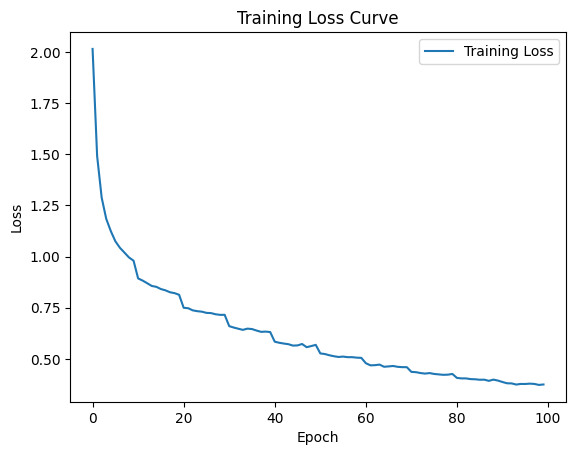

--- Validating on Validation Set ---
### Test or Validation ###


/tmp/ipykernel_3889808/2409967368.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_name, map_location=self.config.device)


Restored model parameters from model_v1/model-80.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 850.54it/s]


Checkpoint 80 Test accuracy: 0.8046
Restored model parameters from model_v1/model-90.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 864.43it/s]


Checkpoint 90 Test accuracy: 0.8106
Restored model parameters from model_v1/model-100.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 855.75it/s]


Checkpoint 100 Test accuracy: 0.8136
--- Testing on Test Set ---
### Test or Validation ###
Restored model parameters from model_v1/model-100.ckpt


100%|██████████| 10000/10000 [00:11<00:00, 868.02it/s]

Checkpoint 100 Test accuracy: 0.8059


In [17]:
#from ImageUtils import parse_record
#from DataReader import load_data, train_vaild_split
#from Model import Cifar

import os
import argparse
import torch

def configure():
    parser = argparse.ArgumentParser()
    # Basic model and training parameters
    parser.add_argument("--batch_size", type=int, default=128, help='training batch size')
    parser.add_argument("--num_classes", type=int, default=10, help='number of classes')
    parser.add_argument("--save_interval", type=int, default=10, help='save checkpoint every save_interval epochs')
    parser.add_argument("--weight_decay", type=float, default=2e-4, help='weight decay rate')
    parser.add_argument("--modeldir", type=str, default='model_v1', help='directory for saving models')
    parser.add_argument("--lr", type=float, default=0.01, help='learning rate')
    parser.add_argument("--gpu", type=int, default=0, help='GPU ID to use')
    parser.add_argument("--use_residual", type=bool, default=True, help='whether to use residual connections')
    parser.add_argument("--use_bn", type=bool, default=True, help='whether to use batch normalization')

    args, unknown = parser.parse_known_args()
    return args


# Parse command-line arguments and configure GPU visibility
config = configure()
os.environ['CUDA_VISIBLE_DEVICES'] = str(config.gpu)

print("--- Preparing Data ---")

# Specify the path to the CIFAR-10 data directory
data_dir = "dataset/cifar-10-batches-py"  # Update with the actual path to your CIFAR-10 data directory

# Load and split the data into training, validation, and test sets
x_train, y_train, x_test, y_test = load_data(data_dir)
x_train_new, y_train_new, x_valid, y_valid = train_vaild_split(x_train, y_train)

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() and config.gpu >= 0 else "cpu")
print(device)
config.device = device

# Initialize the Cifar model with the specified configuration and move it to the selected device
model = Cifar(config).to(device)

# Train the model for 100 epochs and validate with checkpoints at specified epochs
print("--- Starting Training ---")
model.train(x_train_new, y_train_new, max_epoch=100)

print("--- Validating on Validation Set ---")
model.test_or_validate(x_valid, y_valid, checkpoint_num_list=[80, 90, 100])

print("--- Testing on Test Set ---")
model.test_or_validate(x_test, y_test, checkpoint_num_list=[100])
    